In [1]:
# Pre configurations

# stable outputs across the runs
import numpy as np
np.random.seed(42)

#folder to the figures
import os
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MINST

In [2]:
#Get MNIST dataset from scikit
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
#check de features
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# check matrix

X, y = mnist['data'], mnist['target']
X.shape

#70000 images with 784 characteristics (28x28 pixels)

(70000, 784)

In [4]:
y.shape
#a instance for image

(70000,)

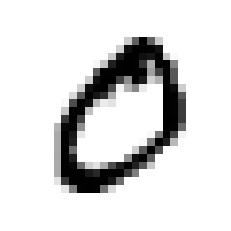

In [5]:
#check a digit

import matplotlib as mpl
import matplotlib.pyplot as plt

a_digit = X[1]
a_digit_image = a_digit.reshape(28,28)

plt.imshow(a_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [6]:
y[1]

'0'

In [7]:
# ML algorithms works generaly with numbers, so convert it a num

y = y.astype(np.uint8)

In [8]:
# train and test division

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


# Train a binary classifier

In [9]:
# Objetive vectors

y_train_0 = (y_train == 0) #True to all the 0, false for other digits
y_test_0 = (y_test == 0)


In [10]:
# Stochastic Gradient Descent classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_0)

SGDClassifier(random_state=42)

In [11]:
#detect number 0 imagenes
sgd_clf.predict([a_digit])

array([ True])

# Performance measures

In [12]:
# First efficiency measurement. Cross validation

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_0, cv=3, scoring='accuracy')

array([0.9854, 0.9847, 0.9865])

In [13]:
#simple classificaitor all in no-0

from sklearn.base import BaseEstimator

class Never0Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
#check the never0classifier

never_0_clf = Never0Classifier()
cross_val_score(never_0_clf, X_train, y_train_0, cv=3, scoring='accuracy')

#only 10% of the imagenes is 0, so we will be rigth the 90% of the time is we check no-0. For these reason, 
#the accuracy test isn't the best in the classifications

array([0.9003 , 0.9035 , 0.90005])

In [15]:
#Confusion matrix
#first, the predictions

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_0, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_0, y_train_pred)

#no-0 53486 "true-negatives"
# "false positives" 591
# "false negatives" 277
# "true positives"

array([[53486,   591],
       [  277,  5646]])

In [17]:
#check the perfect confusion matrix
y_train_perfect_predictions = y_train_0
confusion_matrix(y_train_0, y_train_perfect_predictions)

array([[54077,     0],
       [    0,  5923]])

# Precision and sensibility

In [18]:
#calculate the classifier metrics
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_0, y_train_pred)


0.9052429052429053

In [19]:
recall_score(y_train_0, y_train_pred)

0.9532331588721932

In [21]:
# we can combine both in F value

from sklearn.metrics import f1_score
f1_score(y_train_0, y_train_pred)

0.9286184210526315

# Precision/sensibility compensation

In [32]:
#get the puntuation for instance
y_scores = sgd_clf.decision_function([a_digit])
y_scores

array([21180.55082734])

In [33]:
#SDClassifier use 0 limit, so we have the same value
threshold = 0
y_a_digit_pred = (y_scores > threshold)
y_a_digit_pred

array([ True])

In [37]:
#raise threshold
threshold = 25000
y_a_digit_pred = (y_scores > threshold)
y_a_digit_pred
#if we raise the limit, sensibility goes down. When the limit is 0, it detected the digit like 0, but if we raise the limit, 
#the classifer ignore the digit 

array([False])

In [38]:
#how can we decided the limits?
#First cross_alue_predict to get all the puntuations

y_scores = cross_val_predict(sgd_clf, X_train, y_train_0, cv=3, method='decision_function')

In [40]:
# With these puntuations, use precision_recall_curve() to calculate every limit precision and sensibility
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores)

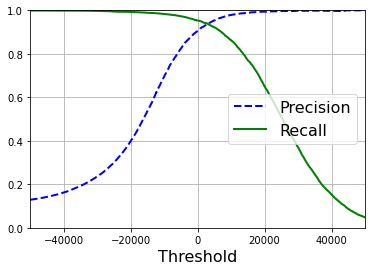

In [49]:
# use matplotlib to representate the precision and sensibility like limit functions
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()



Saving figure precision_vs_recall_plot


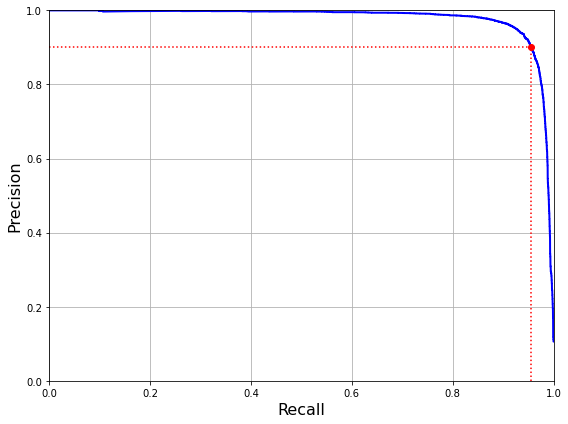

In [50]:
#precision/recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [55]:
#get the minimum limit to have 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

-411.0056907752553

In [56]:
#get predictions  with set precision
y_train_pred_90 =(y_scores >= threshold_90_precision)


In [57]:
#get these predictions precision and recall
precision_score(y_train_0, y_train_pred_90)

0.9000636537237429

In [58]:
recall_score(y_train_0, y_train_pred_90)

0.9549214924869154